# __9 Wrap up__

Goal:
- Tie the loose ends

## ___Setup___

### Module import

In conda env `base`

In [23]:
import pickle
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.optimize import curve_fit

### Key variables

In [2]:
# Reproducibility
seed = 20220609

# Setting working directory
proj_dir   = Path.home() / "projects/plant_sci_hist"
work_dir   = proj_dir / "9_wrap_up"
work_dir.mkdir(parents=True, exist_ok=True)

# plant science corpus with topic assignment info
dir42      = proj_dir / "4_topic_model/4_2_outlier_assign"
corpus_file = dir42 / "table4_2_corpus_with_topic_assignment.tsv.gz"
#corpus_file = dir42 / "test.tsv"

dir44 = proj_dir / "4_topic_model/4_4_over_time"

# country info, pmid, ...
dir75             = proj_dir / "7_countries/7_5_country_over_time"
ci_file           = dir75 / 'ci_pmid_topic.tsv'
c_npub_file       = dir75 / 'country_npub_raw.csv'
t25_toc_stat_file = dir75 / "country_top25_toc_stat.csv"

# SJR and pdjity (pmid, date, journal, issn, topic, year)
dir81            = proj_dir / '8_impact/8_1_topic'
pdjity_file      = dir81 / "table_pdjity.tsv"
file_d_d_metric  = dir81 / 'sjr_metric_dicts.pkl'

# So PDF is saved in a format properly
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "sans-serif"

## ___Finalize pub number graphs___

### Pub number graph after removing China

Related graphs:
- 1_1: number pubs per year in pubmed
- 4_4: number pubs per year in plant science corpus

Focus on 1951 to 2020

In [16]:
file_docs_year_df = dir44 / "table_4_4_docs_year_df.csv"
docs_year_df = pd.read_csv(file_docs_year_df, index_col=0).drop(2021)
docs_year_df.iloc[-2:]

,Count
2019,26963
2020,30228


In [21]:
# Get pub number for CHN
file_c25_year_count = dir75 / "country_top25_year_count.csv"
c25_year_count = pd.read_csv(file_c25_year_count, index_col=0)
pub_num_CHN    = c25_year_count.loc["CHN"]

# convert to dictionary, note that the indices are strings, need to be integer
pub_num_CHN_dict = {int(k):v for k,v in pub_num_CHN.items()}

pub_num_CHN['2019'], pub_num_CHN_dict[2019]

(7869, 7869)

In [15]:
# add missing years
pub_num_CHN_list = []
for yr in docs_year_df.index:
  if yr in pub_num_CHN_dict:
    pub_num_CHN_list.append(pub_num_CHN_dict[yr])
  else:
    pub_num_CHN_list.append(0)

docs_year_df.shape, len(pub_num_CHN_list)

((96, 2), 96)

In [17]:
### Substract CHN from total then add to df 
docs_year_df["CHN"] = pub_num_CHN_list
docs_year_df.head(2)

,Count,CHN
1917,1,0
1918,1,0


In [20]:
docs_year_df['Count_no_CHN'] = docs_year_df['Count'] - docs_year_df['CHN']
docs_year_df.head(2), docs_year_df.tail(2)

(      Count  CHN  Count_no_CHN
 1917      1    0             1
 1918      1    0             1,
       Count   CHN  Count_no_CHN
 2019  26963  7869         19094
 2020  30228  9031         21197)

In [27]:
target_yrs = [y for y in range(1951, 2021)]

docs_year_df_part = docs_year_df.loc[target_yrs]
docs_year_df_part.head(2), docs_year_df_part.tail(2)

(      Count  CHN  Count_no_CHN
 1951      2    0             2
 1952      2    0             2,
       Count   CHN  Count_no_CHN
 2019  26963  7869         19094
 2020  30228  9031         21197)

In [28]:
### Plot exponential fit

X = docs_year_df_part.index
Y = docs_year_df_part["Count_no_CHN"].values

def exp_func(X, a, b, c):
  return a*np.exp(b*X) + c

# Curve fit
popt_exp, _ = curve_fit(exp_func, X, Y, p0=(1, 1e-6, 1), maxfev=10000)
popt_exp

array([ 1.97174697e-41,  5.13730308e-02, -1.24134120e+03])

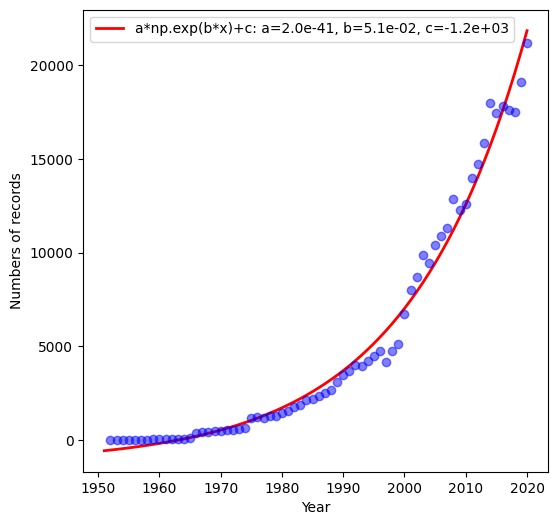

In [30]:
# Plotting
fig_fit_yr_docnum = work_dir / "fig_9_year_docnum_noCHN_exponential_fit.pdf"

#y_pred = [exp_func(x, *popt_exp) for x in X]
plt.figure(figsize=(6, 6))

# plot legend in scientific number:
#https://www.scaler.com/topics/python-scientific-notation/
#https://sparrow.dev/python-scientific-notation/

plt.plot(X, exp_func(X, *popt_exp),'r',linewidth=2, 
        label='a*np.exp(b*x)+c: a=%.1e, b=%.1e, c=%.1e' % tuple(popt_exp))
plt.plot(X[1:], Y[1:], 'bo', alpha=0.5)
#plt.plot(x[1:], y_pred[1:], '-b')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Numbers of records")
plt.savefig(fig_fit_yr_docnum, format='pdf')
plt.show()

### Plot number graph of top 10 without CHN